In [1]:
import os
import time
from pathlib import Path

def findAllFiles(path):
    res = []
    path, folders, files = next(os.walk(path))
    if folders:
        for f in folders:
            res.extend(findAllFiles(os.path.join(path, f)))
    res.extend([os.path.join(path, f) for f in files if not f.endswith(".txt")])
    return res

ds_name = "imagenette2-320"
ds_path = Path("/home/gustav/Downloads/") / ds_name
ds_cats = ["train", "val"]

res_dir = Path("/home/gustav/Downloads/ds_proc/")

os.makedirs(res_dir, exist_ok=True)

In [2]:
%%time

import os
import dng
import cfa
import noise
import numpy as np
from PIL import Image


def add_noise_to_ds_category(ds_path, res_dir, suffix, noise, noise_amt, size):
    noise_type, noise_func = noise
    save_path_png          = res_dir / "png" / noise_type / f"{noise_amt*100:g}pct" / suffix
    save_path_dng          = res_dir / "dng" / noise_type / f"{noise_amt*100:g}pct" / suffix
    save_path_npy          = res_dir / "npy" / noise_type / f"{noise_amt*100:g}pct" / suffix
    os.makedirs(save_path_png, exist_ok=True)
    os.makedirs(save_path_dng, exist_ok=True)
    os.makedirs(save_path_npy, exist_ok=True)
    
    imgs = findAllFiles(ds_path / suffix)[:10]
    
    
    for n, img in enumerate(imgs):
        img_rgb       = np.array(Image.open(img).convert("RGB"), dtype=np.uint8)
        
        # Center crop
        h, w, c = img_rgb.shape
        offset_x = (h - size) // 2
        offset_y = (w - size) // 2
        
        img_crop      = np.zeros((size,size,c))
        img_crop      = img_rgb[offset_x:(offset_x+size), offset_y:(offset_y+size)]
        img_rgb_noise = noise_func(img_crop, amount=noise_amt)
        
        # Save Noisy RGB image
        Image.fromarray(img_rgb_noise).save(save_path_png / f"{n}.png", format="PNG")
        
        img_cfa = cfa.rgb_to_cfa(img_rgb_noise.astype(np.uint16) * 2**8, cfa.rgb_kf)   

        # Save noisy CFA
        dng.write(img_cfa, filename=str(save_path_dng / str(n)))
        np.save(save_path_npy / str(n), img_cfa)


def add_noise_to_ds(ds_path, res_dir, suffixes, noises, noise_amts, size):
    for noise in noises:
        for noise_amt in noise_amts:
            for suffix in suffixes:
                add_noise_to_ds_category(ds_path, res_dir, suffix, noise, noise_amt, size)

noises = [
    ("gaussian",   noise.gaussian_noise),
    ("speckle",    noise.norm_speckle_noise),
    ("saltpepper", noise.salt_pepper_noise)
]

noise_amts = [0.1, 0.3, 0.7]
suffixes   = ["train", "val"]
size = 320

add_noise_to_ds(ds_path, res_dir, suffixes, noises, noise_amts, size)

StopIteration: 

In [3]:
%%time

from itertools import product
from multiprocessing import Pool, cpu_count

def f(args):
    noise, noise_amt, suffix = args
    add_noise_to_ds_category(ds_path, res_dir, suffix, noise, noise_amt, size)

def p_add_noise_to_ds(ds_path, res_dir, suffixes, noises, noise_amts, size):
    args = list(product(noises, noise_amts, suffixes))

    p = Pool(processes=cpu_count())
    p.map(f, args)

noises = [
    ("gaussian",   noise.gaussian_noise),
    ("speckle",    noise.norm_speckle_noise),
    ("saltpepper", noise.salt_pepper_noise)
]

noise_amts = [0.1, 0.3, 0.7]
suffixes   = ["train", "val"]
size = 320

p_add_noise_to_ds(ds_path, res_dir, suffixes, noises, noise_amts, size), cpu_count()

CPU times: user 13.1 ms, sys: 43.7 ms, total: 56.7 ms
Wall time: 91.3 ms


(None, 8)

In [4]:
import noise
import importlib

img     = findAllFiles(ds_path / "train")[0]
img_rgb = np.array(Image.open(img).convert("RGB"), dtype=np.uint8)

def norm_speckle_noise(img, amount=.3):
    h, w, c = img.shape
    d_max   = np.iinfo(img.dtype).max

    gen     = np.random.default_rng()
    noise   = np.expand_dims(gen.normal(0, amount, (h, w)), 2)

    res     = img.astype(np.int64) + (img.astype(np.int64) * noise)

    return np.clip(res, 0, d_max).astype(img.dtype)

importlib.reload(noise)

display(Image.fromarray(noise.exp_speckle_noise(img_rgb, 0.00001)))
display(Image.fromarray(noise.exp_speckle_noise(img_rgb, 0.3)))
display(Image.fromarray(noise.exp_speckle_noise(img_rgb, 0.9)))


StopIteration: 

In [ ]:
/archive/index.html%%time

import dng
import cfa
import numpy as np
from PIL import Image


suffix         = "train"
save_path      = ds_path + "dng/"
imgs           = findAllFiles(ds_path + suffix)[:10000]
cell_x, cell_y = (64,64)
pad_x, pad_y   = ((226 - 64) // 2, (226 - 64) // 2)

for n, img in enumerate(imgs):
    img     = Image.open(img).convert("RGB")
    img_arr = cfa.rgb_to_cfa(np.array(img, dtype=np.uint16) * 2**8, cfa.rgb_kf)
    
    res = np.zeros((pad_x*2 + cell_x, pad_y*2 + cell_y), dtype=np.uint16)
    res[pad_x:pad_x+cell_x, pad_y:pad_y+cell_y] = img_arr
    
    dng.write(img_arr, filename=f"{save_path}{suffix}_{n}")

In [ ]:
f"{0.3*100:g}pct"

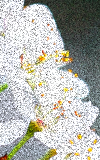

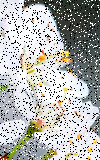

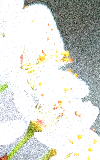

In [5]:
img_rgb = np.array(Image.open("/home/gustav/Pictures/flower.png").convert("RGB"), dtype=np.uint8)

display(Image.fromarray(noise.norm_speckle_noise(img_rgb, 0.2)))
display(Image.fromarray(noise.salt_pepper_noise(img_rgb, 0.2)))
display(Image.fromarray(noise.gaussian_noise(img_rgb, 0.2)))

In [6]:
img_rgb = np.array(Image.open("/home/gustav/Pictures/flower.png").convert("RGB"), dtype=np.uint8)
display(Image.fromarray(img_rgb[]))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (331018042.py, line 2)

In [62]:
import torch.nn.functional as F
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from PIL import Image
import torch as t
from scipy.ndimage import median_filter

def sparse_ones(shape: tuple, coords: list):
    """Takes a tuple for SHAPE, and a list of indicies COORDS.

    Returns an array ARR, where ARR.shape = SHAPE and there is a 1 at every
    indicie in COORDS"""

    arr = np.zeros(shape)
    for coor in coords:
        arr[coor] = 1.0

    return arr

# Img to CFA
bayer_kf = sparse_ones((3,2,2), [(0,0,1),(1,0,0),(2,1,0),(1,1,1)])
# Not ready, rgb_to_cfa has to many output channels
CYYM_kf  = sparse_ones((3,2,2), [(0,0,1),(1,0,0),(2,1,0),(1,1,1),(1,0,1),(2,0,0),(0,1,0),(2,1,1)])
RYYB_kf  = sparse_ones((3,2,2), [(0,0,1),(1,0,0),(0,0,0),(2,1,0),(1,1,1),(0,1,1)])

def rgb_to_cfa(img, kernel=bayer_kf):
    c, h, w    = img.shape
    kc, kw, kh = kernel.shape

    if not c == kc:
        raise Exception(f"Differing number of kernel and image channels! c: {c}, kc: {kc}")

    res = t.zeros((c, h, w))

    for channel in range(c):
        for off_w, r in enumerate(kernel[channel]):
            for off_h, a in enumerate(r):
                res[channel, off_h::kh, off_w::kw] += img[channel, off_h::kh, off_w::kw] * a

    return res

def bilinear(img):
    k_z  = [[0] * 3] * 3
    k_rb = [[.25, .5, .25],
            [ .5,  0,  .5],
            [.25, .5, .25]]
    k_g  = [[  0,.25,   0],
            [.25,  0, .25],
            [  0,.25,   0]]
    kernel = t.Tensor([
        [k_rb, k_z,  k_z],
        [ k_z, k_g,  k_z],
        [ k_z, k_z, k_rb]
    ])
    
    res  = img.clone().unsqueeze(0)
    res += F.conv2d(res, weight=kernel, padding=1)
    return res.squeeze(0)

img = (pil_to_tensor(Image.open("./unknown.png")).to(torch.float32)) / 255
cfa = rgb_to_cfa(img)

display(to_pil_image(img))
display(to_pil_image(cfa))

dem = bilinear(cfa)[:, 1:-1, 1:-1]
display(to_pil_image(dem))

pro = dem.clone()
pro *= torch.quantile(dem, .99)
pro = torch.clamp(dem, 0, 1)
pro = median_filter(np.array(pro).transpose(1,2,0), (3,3,1))

display(to_pil_image(pro))

In [15]:
dir(cfa)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'colorize_cfa',
 'np',
 'rgb_kf',
 'rgb_to_cfa',
 'sparse_ones']